# Classifying phases of the Ising model with Bayesian regression


Difference between Bayesian and classical approach to statistics:
Classical:
    Frequentist. Probability represents empirical ratio of event / possible events
    The data is the stochastic elements, the parameter is fixed.
    Suffers from a number of pathologies
    
Bayesian:
    Probability represents OUR uncertainty.
    The data isn't the stochastic element, but our parameter estimate is
    Uses a prior, representing that one usually has prior information
    or the prior can represent complete ignorance
    
   
 
Various regularization schemes are mathematically equivalent to using certain priors


Bayesian linear regression:
    Full posterior p(w,sigma|D), meaning we get the knowledge of how vectors w' in the neighbourhood of w compares. 
    Can provide a certainty estimate, eg. credible interval or highest posterior density region. We will use the latter. 
        what is this when doing linear regression?
        
       
    Gaussian prior is equivalent to L2 regularization in classical statistics
    
    Bayesian model selection for linreg?
    
    gives uncertainty estimates both for the w and y
    

"In most statistical situations
(excluding game theoretic ones), assuming nature is an adversary is not a reasonable assumption." 

# Bayesian linear regression

### The 1D ising model

We randomly generate $N$ states of the 1D ising model (meaning N 1D vectors consisting of -1s and 1s) and calculate their energies using the following Hamiltonian:
$$
H[\vec{S^i}] = - J\sum_{j=1}^LS_j^i S_{j+1}^i
$$
Where $S_j^i$ is the j'th element of the i'th state $\vec{S^i}$. We set the value $J=1$.

We will then try to see if we can re-extract this Hamiltonian from the data using Bayesian Linear regression.

### Producing 1D Ising data:

In [35]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)


import warnings
# Comment this to turn on warnings
warnings.filterwarnings('ignore')

### define Ising model aprams
# system size
L=40

# create 10000 random Ising states
states=np.random.choice([-1, 1], size=(900,L))

def ising_energies(states):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    """
    L = states.shape[1]
    J = np.zeros((L, L),)
    for i in range(L): 
        J[i,(i+1)%L]=-1.0 # interaction between nearest-neighbors
        
    # compute energies
    E = np.einsum('...i,ij,...j->...',states,J,states)

    return E
# calculate Ising energies
energies=ising_energies(states)

### Remapping data for regression

We pretend that we're ignorant about the Hamiltonian used to generate the above data. That means that the values aren't the only unknowns, but the shape of it as well. So we need to consider the all-to-all Hamiltonian

$$
H_{model}[\vec{S^i}] = - \sum_{j=1}^L\sum_{k=1}^L J_{j,k}S_j^iS_{k}^i
$$

We see that the actual Hamiltonian we used above is just a special case of this, with $J_{j,k} = \delta_{j,k+1}$.



Taking the outer product

$\vec{\mathbf{x}} \rightarrow \phi(\vec{\mathbf{x}})=\vec{\mathbf{x}}\otimes \vec{\mathbf{x}}$

then we make the vector $\phi(\vec{\mathbf{x}})$ one-dimensional

In [53]:
new_states = np.einsum('bi,bo->bio',states,states)
new_states = new_states.reshape(new_states.shape[0],-1)

In [51]:
import time
from sys import exit
t0 = time.time()


n = new_states.shape[0]   # number of data
D = new_states.shape[1]   # data dimension

# Prior:
variance = 1
w0 = np.zeros(D)
tau = 1 # 1 means unitary gaussian
V0 = tau**2*np.identity(D)  # precision matrix of prior
V0_inv = np.linalg.inv(V0)


X = new_states # data matrix with data as rows
y = energies


VN_inv = V0_inv + np.dot(X.T,X) / variance
VN = np.linalg.inv(VN_inv)

wN = np.dot(np.dot(VN,V0_inv),w0) + np.dot(np.dot(VN,X.T),y) / variance
t1 = time.time()-t0

print(t1)

10.829948663711548


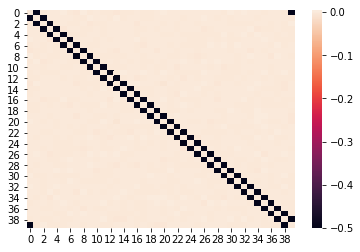

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.heatmap(wN.reshape(40,40))
plt.show()
#plt.imshow(wN.reshape(40,40))
#plt.show()

Gir mening at den fordeler verdiene i w sånn, fordi 0.5^2 + 0.5^2 er mindre enn 1^2 + 1^2 

Det at Lasso er mer riktig er ikke fordi den henter det ut fra dataen, men pga. prioren.


### Test data




In [69]:
test_states=np.random.choice([-1, 1], size=(300,L))
# calculate Ising test energies
test_energies=ising_energies(test_states)

# remapping states:
test_states = np.einsum('bi,bo->bio',test_states,test_states)
test_states = test_states.reshape(test_states.shape[0],-1)

predicted_energies = np.dot(test_states, wN)


### R^2 - coefficient of determination
y_true_avg = np.mean(test_energies)
residuals = predicted_energies - test_energies
u = np.dot(residuals,residuals)
v = test_energies - y_true_avg
v = np.dot(v,v)

R_squared = 1 - u/v

print(R_squared)


0.9998683892131723


## The 2d Ising model
### Loading Ising model data

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

def read_t(t,root="/home/samknu/MyRepos/MLProjectIsingModel/data/IsingData/"):
    data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
    return np.unpackbits(data).astype(int).reshape(-1,1600)

temperatures = np.arange(0.25, 4., step=0.25)   

MemoryError: 